In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='42a1057d-f875-4592-88b3-725dfabd6d4b', project_access_token='p-3898c4ed4d57600eb9d7ce48d8a7f029a9ec55a8')
pc = project.project_context


# Explore UK Crime Data with Pandas and GeoPandas


## Table of Contents

1. [Introduction to GeoPandas](#geopandas)<br>
2. [Getting ready](#ready)<br>
3. [London boroughs](#boroughs)<br>
    3.1. [Load data](#load1)<br>
    3.2. [Explore data](#explore1)<br>
4. [Crime data](#crime)<br>
    4.1. [Load data](#load2)<br>
    4.2. [Explore data](#explore2)<br>
5. [OSM data](#osm)<br>
    5.1. [Load data](#load3)<br>
    5.2. [Explore data](#explore3)<br>

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

<a id="geopandas"></a>
## 1. Introduction to GeoPandas

> If have not used Pandas before, please read through this [10 minute tutorial](http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) or check out this [workshop](https://github.com/IBMDeveloperUK/pandas-workshop/blob/master/README.md).

A GeoDataSeries or GeoDataFrame is very similar to a Pandas DataFrame, but has an additional column with the geometry. You can load a file, or create your own:

In [3]:
df = pd.DataFrame({'city':       ['London','Manchester','Birmingham','Leeds','Glasgow'],
        'population': [9787426,  2553379,     2440986,    1777934, 1209143],
        'area':       [1737.9,   630.3,       598.9,      487.8,   368.5 ],
        'latitude':   [51.50853, 53.48095,    52.48142,   53.79648,55.86515],
        'longitude':  [-0.12574, -2.23743,    -1.89983,   -1.54785,-4.25763]})

df['geometry']  = list(zip(df.longitude, df.latitude))

df['geometry'] = df['geometry'].apply(Point)

cities = gpd.GeoDataFrame(df, geometry='geometry')
cities.head()

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)
1,Manchester,2553379,630.3,53.48095,-2.23743,POINT (-2.23743 53.48095)
2,Birmingham,2440986,598.9,52.48142,-1.89983,POINT (-1.89983 52.48142)
3,Leeds,1777934,487.8,53.79648,-1.54785,POINT (-1.54785 53.79648)
4,Glasgow,1209143,368.5,55.86515,-4.25763,POINT (-4.25763 55.86515)


Creating a basic map is similar to creating a plot from a Pandas DataFrame:

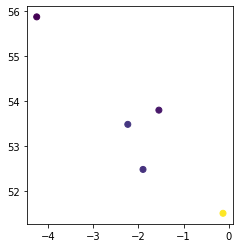

In [4]:
cities.plot(column='population');

As `cities` is a DataFrame you can apply data manipulations, for instance:

In [5]:
cities['population'].mean()

3553773.6

### Points vs Lines vs Polygons

We need some more data! Points by squeezing out the geometry for each city:

In [6]:
lon_point = cities.loc[cities['city'] == 'London', 'geometry'].squeeze()
man_point = cities.loc[cities['city'] == 'Manchester', 'geometry'].squeeze()
birm_point = cities.loc[cities['city'] == 'Birmingham', 'geometry'].squeeze()
leeds_point = cities.loc[cities['city'] == 'Leeds', 'geometry'].squeeze()

Lines between 2 cities by creating a LineString between 2 points:

In [7]:
lon_man_line = gpd.GeoSeries(LineString([lon_point, man_point]))
man_birm_line = gpd.GeoSeries(LineString([man_point, birm_point]))
birm_lon_line = gpd.GeoSeries(LineString([birm_point,lon_point]))
leeds_man_line = gpd.GeoSeries(LineString([leeds_point, man_point]))
birm_leeds_line = gpd.GeoSeries(LineString([birm_point,leeds_point]))

A polygon between 3 cities by creating a Polygon between 3 points:

In [8]:
Polygon([[lon_point.x,lon_point.y],[man_point.x,man_point.y],[lon_point.x,lon_point.y]])
lon_man_birm_polygon = gpd.GeoSeries(Polygon([[lon_point.x,lon_point.y],[man_point.x,man_point.y],[birm_point.x,birm_point.y],[lon_point.x,lon_point.y]]))
leeds_man_birm_polygon = gpd.GeoSeries(Polygon([[leeds_point.x,leeds_point.y],[man_point.x,man_point.y],[birm_point.x,birm_point.y]]))

And plot all of them together:

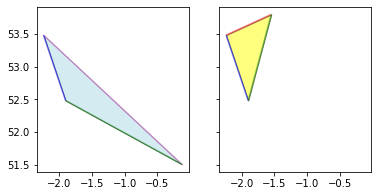

In [9]:
fig, (poly1,poly2) = plt.subplots(ncols=2, sharex=True, sharey=True)

lon_man_birm_polygon.plot(ax=poly1, color='lightblue', edgecolor='black',alpha=0.5);
lon_man_line.plot(ax=poly1,color='violet',alpha=0.5);
man_birm_line.plot(ax=poly1,color='blue',alpha=0.5);
birm_lon_line.plot(ax=poly1,color='green',alpha=0.5);

leeds_man_birm_polygon.plot(ax=poly2, color='yellow', edgecolor='black',alpha=0.5);
leeds_man_line.plot(ax=poly2,color='red',alpha=0.5);
man_birm_line.plot(ax=poly2,color='blue',alpha=0.5);
birm_leeds_line.plot(ax=poly2,color='green',alpha=0.5);

### Overlay

With overlay you can combine geometries, for instance union, difference, symmetrical difference and intersection are some of the operations that can be performed.

Let's combine the 2 polygons:

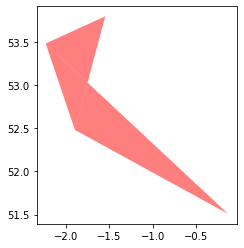

In [10]:
poly1 = gpd.GeoDataFrame({'geometry': lon_man_birm_polygon})
poly2 = gpd.GeoDataFrame({'geometry': leeds_man_birm_polygon})

gpd.overlay( poly1, poly2, how='union').plot(color='red',alpha=0.5);

### Buffer

In [11]:
cities1 = cities[0:1].copy()
cities1.head()

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)


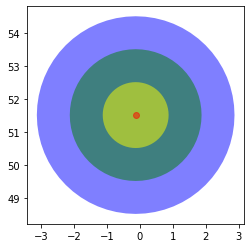

In [12]:
base = cities1.buffer(3).plot(color='blue',alpha=0.5);
cities1.buffer(2).plot(ax=base,color='green',alpha=0.5);
cities1.buffer(1).plot(ax=base,color='yellow',alpha=0.5);
cities1.plot(ax=base,color='red',alpha=0.5);

### Spatial relationships

There are several functions to check geospatial relationships: `equals`, `contains`, `crosses`, `disjoint`,`intersects`,`overlaps`,`touches`,`within` and `covers`. These all use `shapely`: read more [here](https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships) and some more background [here](https://en.wikipedia.org/wiki/Spatial_relation).

A few examples:

In [13]:
cities.head()

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)
1,Manchester,2553379,630.3,53.48095,-2.23743,POINT (-2.23743 53.48095)
2,Birmingham,2440986,598.9,52.48142,-1.89983,POINT (-1.89983 52.48142)
3,Leeds,1777934,487.8,53.79648,-1.54785,POINT (-1.54785 53.79648)
4,Glasgow,1209143,368.5,55.86515,-4.25763,POINT (-4.25763 55.86515)


In [14]:
cities1.head()

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)


In [15]:
cities1.contains(lon_point)

0    True
dtype: bool

In [16]:
cities1[cities1.contains(lon_point)]

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)


In [17]:
cities[cities.contains(man_point)]

,city,population,area,latitude,longitude,geometry
1,Manchester,2553379,630.3,53.48095,-2.23743,POINT (-2.23743 53.48095)


The inverse of `contains`:

In [18]:
cities[cities.within(cities1)]

,city,population,area,latitude,longitude,geometry
0,London,9787426,1737.9,51.50853,-0.12574,POINT (-0.12574 51.50853)


In [19]:
cities[cities.disjoint(lon_point)]

,city,population,area,latitude,longitude,geometry
1,Manchester,2553379,630.3,53.48095,-2.23743,POINT (-2.23743 53.48095)
2,Birmingham,2440986,598.9,52.48142,-1.89983,POINT (-1.89983 52.48142)
3,Leeds,1777934,487.8,53.79648,-1.54785,POINT (-1.54785 53.79648)
4,Glasgow,1209143,368.5,55.86515,-4.25763,POINT (-4.25763 55.86515)


<a id="ready"></a>
## 2. Getting ready

### 2.1. Add data to Cloud Object Store (COS)
The data for this workshop needs to be added to your project. Go to the GitHub repo and download the files in the [data folder](https://github.com/IBMDeveloperUK/python-geopandas-workshop/tree/master/data) to your machine. 

Add the files in the data menu on the right of the notebook (click the 1010 button  at the top right if you do not see this) into COS:

- boundaries.zip
- 2018-1-metropolitan-street.zip
- 2018-2-metropolitan-street.zip
- 2018-metropolitan-stop-and-search.zip
- london_inner_pois.zip


### 2.2. Project Access token

As the data files are not simple csv files, we need a little trick to load the data. The first thing you need is a project access token to programmatically access COS.

Click the 3 dots at the top of the notebook to insert the project token that you created earlier. This will create a new cell in the notebook that you will need to run first before continuing with the rest of the notebook. If you are sharing this notebook you should remove this cell, else anyone can use you Cloud Object Storage from this project.

> If you cannot find the new cell it is probably at the top of this notebook. Scroll up, run the cell and continue with section 2.3

### 2.3. Helper function to load data into notebook

The second thing you need to load data into the notebook is the below help function. Data will be copied to the local project space and loaded from there. The below helper function will do this for you. 

In [20]:
# define the helper function 
def download_file_to_local(project_filename, local_file_destination=None, project=None):
    """
    Uses project-lib to get a bytearray and then downloads this file to local.
    Requires a valid `project` object.
    
    Args:
        project_filename str: the filename to be passed to get_file
        local_file_destination: the filename for the local file if different
        
    Returns:
        0 if everything worked
    """
    
    project = project
    
    # get the file
    print("Attempting to get file {}".format(project_filename))
    _bytes = project.get_file(project_filename).read()
    
    # check for new file name, download the file
    print("Downloading...")
    if local_file_destination==None: local_file_destination = project_filename
    
    with open(local_file_destination, 'wb') as f: 
        f.write(bytearray(_bytes))
        print("Completed writing to {}".format(local_file_destination))
        
    return 0

<a id="boroughs"></a>
## 3. London boroughs

<a id="load1"></a>
### 3.1. Load data

Geospatial data comes in many formats, but with GeoPandas you can read most files with just one command. For example this geojson file with the London boroughs:

In [21]:
# load data from a url
boroughs = gpd.read_file("https://skgrange.github.io/www/data/london_boroughs.json")
boroughs.head()

,id,name,code,area_hectares,inner_statistical,geometry
0,1,Kingston upon Thames,E09000021,3726.117,0,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,2,Croydon,E09000008,8649.441,0,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51..."
2,3,Bromley,E09000006,15013.487,0,"MULTIPOLYGON (((0.01213 51.29960, 0.01196 51.2..."
3,4,Hounslow,E09000018,5658.541,0,"MULTIPOLYGON (((-0.24456 51.48870, -0.24468 51..."
4,5,Ealing,E09000009,5554.428,0,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."


<a id="explore1"></a>
### 3.2. Explore data

To plot a basic map add `.plot()` to a geoDataFrame.  

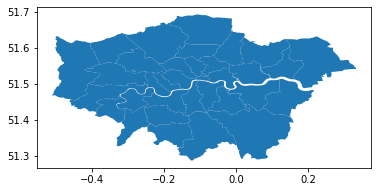

In [22]:
boroughs.plot();

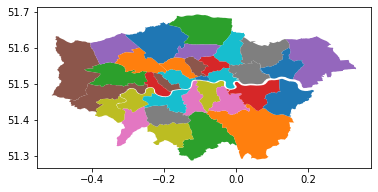

In [23]:
boroughs.plot(column='code');

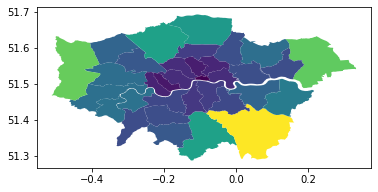

In [24]:
boroughs.plot(column='area_hectares');

### Dissolve

The boroughs are made up of many districts that you might want to combine. For this example this can be done by adding a new column and then use `.dissolve()`:

In [25]:
boroughs['all'] = 1
allboroughs = boroughs.dissolve(by='all',aggfunc='sum')
allboroughs.head()

,geometry,id,area_hectares,inner_statistical
all,,,,
1,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861...",561,159469.725,14


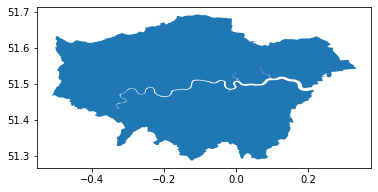

In [26]:
allboroughs.plot();

To change the size of the map and remove the box around the map, run the below:

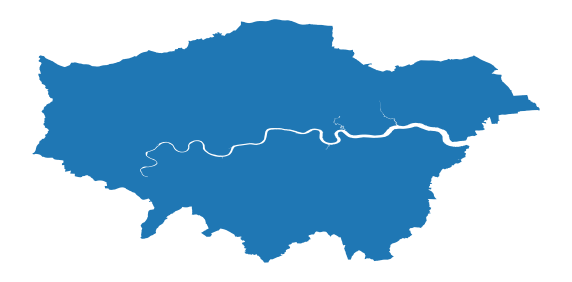

In [27]:
[fig, ax] = plt.subplots(1, figsize=(10, 6))
allboroughs.plot(ax=ax);
ax.axis('off');

### Join

Let's join this with some more data: 

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/IBMDeveloperUK/python-pandas-workshop/master/london-borough-profiles.csv',encoding = 'unicode_escape')

In [29]:
df.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015",...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800.0,5326.0,290.0,30.3,43.2,11.4,73.1,...,6.0,5.6,NaN,2.6,129.0,NaN,NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,Outer London,209000.0,78188.0,3611.0,57.9,32.9,27.2,63.1,...,7.1,3.1,28.5,7.3,228.0,Lab,0.0,100.0,0.0,36.5
2,E09000003,Barnet,Outer London,389600.0,151423.0,8675.0,44.9,37.3,21.1,64.9,...,7.4,2.8,20.7,6.0,134.0,Cons,50.8,NaN,1.6,40.5
3,E09000004,Bexley,Outer London,244300.0,97736.0,6058.0,40.3,39.0,20.6,62.9,...,7.2,3.3,22.7,6.9,164.0,Cons,71.4,23.8,0.0,39.6
4,E09000005,Brent,Outer London,332100.0,121048.0,4323.0,76.8,35.6,20.9,67.8,...,7.2,2.9,24.3,7.9,169.0,Lab,9.5,88.9,1.6,36.3


The columns to join the two tables on are `code` and `Code`. To use the join method, first the index of both tables has to be set to this column.

The below adds the columns from `df` to `boroughs`:


In [30]:
boroughs = boroughs.set_index('code').join(df.set_index('Code'))
boroughs.head()

,id,name,area_hectares,inner_statistical,geometry,all,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
E09000001,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,6.0,5.6,NaN,2.6,129.0,NaN,NaN,NaN,NaN,NaN
E09000002,32,Barking and Dagenham,3779.934,0,"MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...",1,Barking and Dagenham,Outer London,209000.0,78188.0,...,7.1,3.1,28.5,7.3,228.0,Lab,0.0,100.0,0.0,36.5
E09000003,10,Barnet,8674.837,0,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...",1,Barnet,Outer London,389600.0,151423.0,...,7.4,2.8,20.7,6.0,134.0,Cons,50.8,NaN,1.6,40.5
E09000004,15,Bexley,6428.649,0,"MULTIPOLYGON (((0.12021 51.51144, 0.12159 51.5...",1,Bexley,Outer London,244300.0,97736.0,...,7.2,3.3,22.7,6.9,164.0,Cons,71.4,23.8,0.0,39.6
E09000005,9,Brent,4323.270,0,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",1,Brent,Outer London,332100.0,121048.0,...,7.2,2.9,24.3,7.9,169.0,Lab,9.5,88.9,1.6,36.3


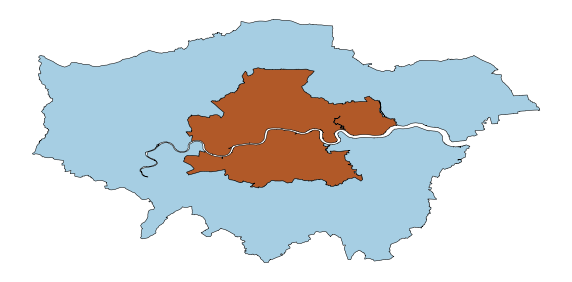

In [31]:
boroughs2 = boroughs.dissolve(by='Inner/_Outer_London',aggfunc='mean')

[fig, ax] = plt.subplots(1, figsize=(10, 6))
boroughs2.plot(column='id', cmap='Paired', linewidth=0.5, edgecolor='black', legend=False, ax=ax);
ax.axis('off');

Below is a map of the average gender pay gap for each borough. 

* add a new column `paygap`
* define the size of the plot
* plot the background 
* add the paygap data and a title

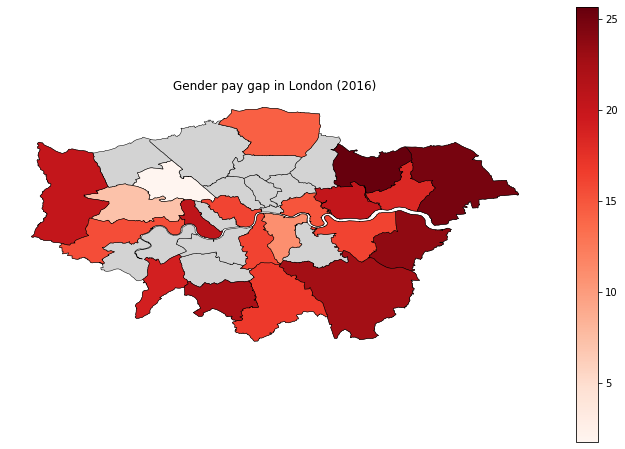

In [32]:
boroughs['paygap'] =((boroughs['Gross_Annual_Pay_-_Male_(2016)'] - boroughs['Gross_Annual_Pay_-_Female_(2016)'])/ \
    boroughs['Gross_Annual_Pay_-_Male_(2016)']) * 100

[fig,ax] = plt.subplots(1, figsize=(12, 8))

boroughs.plot(ax=ax, color="lightgrey", edgecolor='black', linewidth=0.5)

boroughs.dropna().plot(column='paygap', cmap='Reds', edgecolor='black', linewidth=0.5,
               legend=True, ax=ax);
ax.axis('off');
ax.set_title('Gender pay gap in London (2016)');

<a id="crime"></a>
## 4. Crime data

The crime data is pre-processed in this [notebook](https://github.com/IBMDeveloperUK/geopandas-workshop/blob/master/notebooks/prepare-uk-crime-data.ipynb) so it is easier to read here. We will only look at data from 2018.

Data is downloaded from https://data.police.uk/ ([License](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/))

<a id="load2"></a>
### 4.1. Load data

This dataset cannot be loaded into a geoDataFrame directly. Instead the data is loaded into a DataFrame and then converted:

In [33]:
download_file_to_local('2018-1-metropolitan-street.zip', project=project)
download_file_to_local('2018-2-metropolitan-street.zip', project=project)
street = pd.read_csv("./2018-1-metropolitan-street.zip")
street2 = pd.read_csv("./2018-2-metropolitan-street.zip")
street = street.append(street2) 

Attempting to get file 2018-1-metropolitan-street.zip
Downloading...
Completed writing to 2018-1-metropolitan-street.zip
Attempting to get file 2018-2-metropolitan-street.zip
Downloading...
Completed writing to 2018-2-metropolitan-street.zip


In [34]:
download_file_to_local('2018-metropolitan-stop-and-search.zip', project=project)
stop_search = pd.read_csv("./2018-metropolitan-stop-and-search.zip")

Attempting to get file 2018-metropolitan-stop-and-search.zip
Downloading...
Completed writing to 2018-metropolitan-stop-and-search.zip


Clean up of the local directory:

In [35]:
! rm *.zip

In [36]:
street.head()

,Unnamed: 0,Crime ID,Month,Longitude,Latitude,Location,LSOA code,Crime type,Last outcome category,Context
0,0,NaN,2018-01,0.136387,51.589215,On or near Billet Road,E01000027,Anti-social behaviour,NaN,NaN
1,1,NaN,2018-01,0.140634,51.583427,On or near Rams Grove,E01000027,Anti-social behaviour,NaN,NaN
2,2,NaN,2018-01,0.140192,51.582311,On or near Hatch Grove,E01000027,Anti-social behaviour,NaN,NaN
3,3,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN
4,4,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN


In [37]:
stop_search.head()

,Unnamed: 0,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Legislation,Object of search,Outcome,Outcome linked to object of search
0,0,Person search,2018-01-01T00:05:00+00:00,False,NaN,51.425491,-0.220473,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,NaN
1,1,Person search,2018-01-01T00:15:00+00:00,False,NaN,51.459996,-0.116896,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN
2,2,Person and Vehicle search,2018-01-01T00:16:00+00:00,False,NaN,51.542049,-0.380529,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN
3,3,Person and Vehicle search,2018-01-01T00:17:00+00:00,False,NaN,51.613286,-0.065711,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN
4,4,Person search,2018-01-01T00:20:00+00:00,False,NaN,51.461004,-0.115876,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN


#### Convert to geoDataFrames

In [38]:
street['coordinates'] = list(zip(street.Longitude, street.Latitude))
street['coordinates'] = street['coordinates'].apply(Point)
street = gpd.GeoDataFrame(street, geometry='coordinates')
street.head()

,Unnamed: 0,Crime ID,Month,Longitude,Latitude,Location,LSOA code,Crime type,Last outcome category,Context,coordinates
0,0,NaN,2018-01,0.136387,51.589215,On or near Billet Road,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.13639 51.58922)
1,1,NaN,2018-01,0.140634,51.583427,On or near Rams Grove,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.14063 51.58343)
2,2,NaN,2018-01,0.140192,51.582311,On or near Hatch Grove,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.14019 51.58231)
3,3,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.13707 51.58367)
4,4,NaN,2018-01,0.137065,51.583672,On or near Police Station,E01000027,Anti-social behaviour,NaN,NaN,POINT (0.13707 51.58367)


In [39]:
stop_search['coordinates'] = list(zip(stop_search.Longitude, stop_search.Latitude))
stop_search['coordinates'] = stop_search['coordinates'].apply(Point)
stop_search = gpd.GeoDataFrame(stop_search, geometry='coordinates')
stop_search.head()

,Unnamed: 0,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Legislation,Object of search,Outcome,Outcome linked to object of search,coordinates
0,0,Person search,2018-01-01T00:05:00+00:00,False,NaN,51.425491,-0.220473,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,NaN,POINT (-0.22047 51.42549)
1,1,Person search,2018-01-01T00:15:00+00:00,False,NaN,51.459996,-0.116896,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,POINT (-0.11690 51.46000)
2,2,Person and Vehicle search,2018-01-01T00:16:00+00:00,False,NaN,51.542049,-0.380529,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,POINT (-0.38053 51.54205)
3,3,Person and Vehicle search,2018-01-01T00:17:00+00:00,False,NaN,51.613286,-0.065711,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,NaN,POINT (-0.06571 51.61329)
4,4,Person search,2018-01-01T00:20:00+00:00,False,NaN,51.461004,-0.115876,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,POINT (-0.11588 51.46100)


<a id="explore2"></a>
### 4.2. Explore data


<div class="alert alert-success">
 <b>EXERCISE</b> <br/> 
 Explore the data with Pandas. There are no right or wrong answers, the questions below give you some suggestions at what to look at. <br/> 
   <ul>
  <li>How much data is there? Is this changing over time? Can you plot this? </li>
  <li>Are there missing values? Should these rows be deleted?  </li>
  <li>Which columns of the datasets contain useful information? What kind of categories are there and are they all meaningful?</li>
  <li>Which crimes occur most often? And near which location?</li>
  <li>Is there anything you want to explore further or are curious about? Is there any data that you will need for this?</li>      
  <li>Notice anything odd about the latitude and longitudes? Read here how the data is anonymised: https://data.police.uk/about/.</li>       
  </ul> 
    
  Uncomment and run the cells starting with '# %load' to see some of the things that we came up with. Run each cell twice, once to load the code and then again to run the code.  
</div>  

In [40]:
# your data exploration (add as many cells as you need by clicking the `+` at the top of the notebook)


In [41]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer1.py
print ('rows in street: '+str(len(street)))

# columns 
print ('Columns: '+str(street.columns))

# categories
print ('Crime type: '+str(street['Crime type'].unique()))
print ('Last outcome category: '+str(street['Last outcome category'].unique()))
print (street['Context'].unique())

# delete columns
street = street.drop(columns=['Unnamed: 0','Latitude', 'Longitude','Context'])

# convert Date to datetime
street['Month'] = street['Month'].apply(lambda x: datetime.strptime(x, "%Y-%m"))

street.head()


rows in street: 1054600
Columns: Index(['Unnamed: 0', 'Crime ID', 'Month', 'Longitude', 'Latitude', 'Location',
       'LSOA code', 'Crime type', 'Last outcome category', 'Context',
       'coordinates'],
      dtype='object')
Crime type: ['Anti-social behaviour' 'Burglary' 'Criminal damage and arson'
 'Other theft' 'Vehicle crime' 'Violence and sexual offences'
 'Other crime' 'Drugs' 'Robbery' 'Shoplifting' 'Public order'
 'Bicycle theft' 'Theft from the person' 'Possession of weapons']
Last outcome category: [nan 'Offender given community sentence'
 'Investigation complete; no suspect identified'
 'Status update unavailable' 'Offender given a caution'
 'Court result unavailable' 'Defendant found not guilty'
 'Offender given a drugs possession warning' 'Offender sent to prison'
 'Offender given suspended prison sentence'
 'Offender given penalty notice' 'Local resolution'
 'Offender deprived of property' 'Offender fined'
 'Court case unable to proceed' 'Offender otherwise dealt with'


,Crime ID,Month,Location,LSOA code,Crime type,Last outcome category,coordinates
0,NaN,2018-01-01,On or near Billet Road,E01000027,Anti-social behaviour,NaN,POINT (0.13639 51.58922)
1,NaN,2018-01-01,On or near Rams Grove,E01000027,Anti-social behaviour,NaN,POINT (0.14063 51.58343)
2,NaN,2018-01-01,On or near Hatch Grove,E01000027,Anti-social behaviour,NaN,POINT (0.14019 51.58231)
3,NaN,2018-01-01,On or near Police Station,E01000027,Anti-social behaviour,NaN,POINT (0.13707 51.58367)
4,NaN,2018-01-01,On or near Police Station,E01000027,Anti-social behaviour,NaN,POINT (0.13707 51.58367)


In [42]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer2.py
bystreet = street.groupby(['Location','Crime type']).count()
bystreet = bystreet.drop(columns=['Month', 'Last outcome category','coordinates','LSOA code'])
bystreet = bystreet.rename(index=str, columns={"Crime ID": "Number of crimes"})

bystreet.sort_values(by=['Number of crimes'], ascending=False).head()


Number of crimes
Location                  Crime type                                    
On or near Petrol Station Other theft                               9933
On or near Supermarket    Shoplifting                               8444
                          Violence and sexual offences              6689
On or near Shopping Area  Shoplifting                               6637
On or near Supermarket    Other theft                               6262

In [43]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer3.py
# number of data points
print ('rows in stop_search: '+str(len(stop_search)))

# columns 
print ('Columns: '+str(stop_search.columns))

# categories
print ('Policing operation: '+str(stop_search['Policing operation'].unique()))
print ('Legislation: '+str(stop_search['Legislation'].unique()))
print ('Object of search: '+str(stop_search['Object of search'].unique()))
print ('Outcome: '+str(stop_search['Outcome'].unique()))
print ('Outcome linked to object of search: '+str(stop_search['Outcome linked to object of search'].unique()))

# delete columns
stop_search = stop_search.drop(columns=['Unnamed: 0','Latitude', 'Longitude', 'Part of a policing operation', 'Policing operation', 'Outcome linked to object of search'])

# convert Date to datetime
stop_search['Date'] = stop_search['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S+00:00"))

stop_search.head()


rows in stop_search: 149284
Columns: Index(['Unnamed: 0', 'Type', 'Date', 'Part of a policing operation',
       'Policing operation', 'Latitude', 'Longitude', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'coordinates'],
      dtype='object')
Policing operation: [nan]
Legislation: ['Misuse of Drugs Act 1971 (section 23)'
 'Police and Criminal Evidence Act 1984 (section 1)'
 'Firearms Act 1968 (section 47)'
 'Criminal Justice and Public Order Act 1994 (section 60)']
Object of search: ['Controlled drugs' 'Offensive weapons' 'Stolen goods' nan
 'Evidence of offences under the Act' 'Fireworks'
 'Articles for use in criminal damage' 'Firearms'
 'Anything to threaten or harm anyone']
Outcome: ['Khat or Cannabis warning' 'Arrest' 'A no further action disposal'
 'Penalty Notice for Disorder' 'Community resolution'
 'Summons / charged by post' 'Caution (simple or conditional)']
Outcome linked to object of search: [nan]


,Type,Date,Legislation,Object of search,Outcome,coordinates
0,Person search,2018-01-01 00:05:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,POINT (-0.22047 51.42549)
1,Person search,2018-01-01 00:15:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,POINT (-0.11690 51.46000)
2,Person and Vehicle search,2018-01-01 00:16:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,POINT (-0.38053 51.54205)
3,Person and Vehicle search,2018-01-01 00:17:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,POINT (-0.06571 51.61329)
4,Person search,2018-01-01 00:20:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,POINT (-0.11588 51.46100)


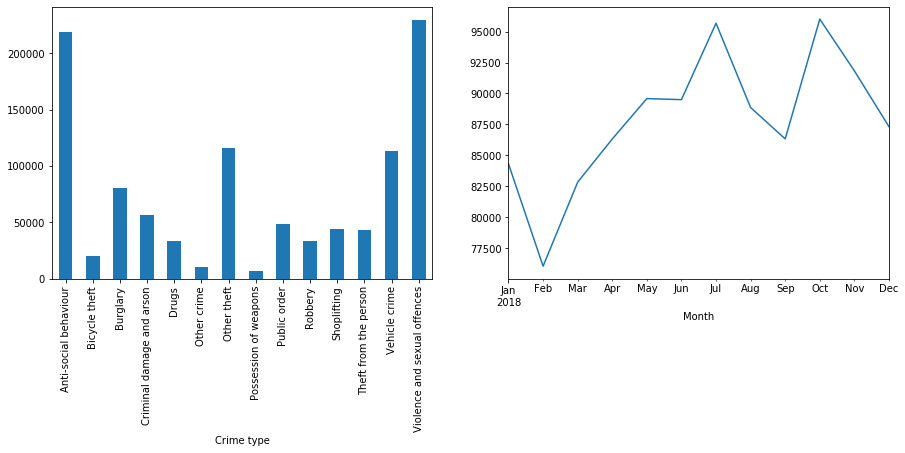

In [44]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer4.py
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

street['Crime type'].groupby(street['Crime type']).count().plot.bar(ax=ax1);

street['Crime type'].groupby(street['Month']).count().plot(ax=ax2);


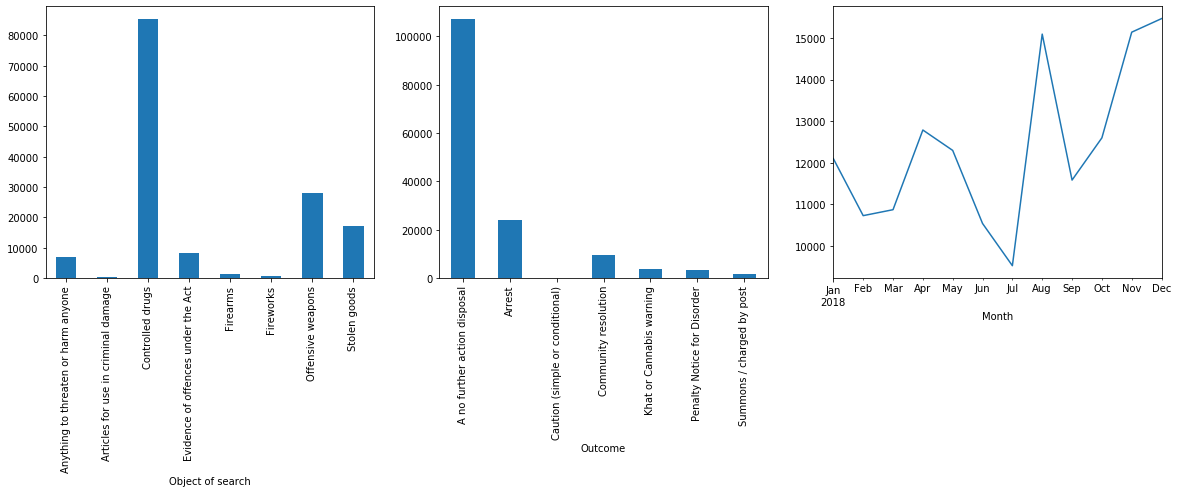

In [45]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer5.py
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

stop_search['Object of search'].groupby(stop_search['Object of search']).count().plot.bar(ax=ax1);

stop_search['Outcome'].groupby(stop_search['Outcome']).count().plot.bar(ax=ax2);

stop_search['Month'] = stop_search.Date.dt.to_period("M")
stop_search['Object of search'].groupby(stop_search['Month']).count().plot(ax=ax3);


Some things we noticed:
* The number of stop and searches seems to go up. That is something you could investigate further. Is any of the categories increasing? 
* Another interesting question is how the object of search and the outcome are related. Are there types of searches where nothing is found more frequently? 
* In the original files there are also columns of gender, age range and ethnicity. If you want to explore this further you can change the code and re-process the data from this [notebook](https://github.com/IBMDeveloperUK/geopandas-workshop/blob/master/notebooks/prepare-uk-crime-data.ipynb) and use the full dataset.
* And how could you combine the two datasets?

### Spatial join

> The below solution was found [here](https://gis.stackexchange.com/questions/306674/geopandas-spatial-join-and-count) after googling for 'geopandas count points in polygon'

The coordinate system (`crs`) needs to be the same for both GeoDataFrames. 

In [46]:
print(boroughs.crs)
print(stop_search.crs)

{'init': 'epsg:4326'}
None


Add a borough to each point with a spatial join. This will add the `geometry` and other columns from `boroughs2` to the points in `stop_search`. 

In [47]:
stop_search.crs = boroughs.crs
dfsjoin = gpd.sjoin(boroughs,stop_search) 
dfsjoin.head()

,id,name,area_hectares,inner_statistical,geometry,all,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,...,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections,paygap,index_right,Type,Date,Legislation,Object of search,Outcome,Month
E09000001,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,102509,Person search,2018-09-21 19:00:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,2018-09
E09000001,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,80693,Person search,2018-08-05 04:05:00,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,2018-08
E09000001,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,2010,Person and Vehicle search,2018-01-06 15:30:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,2018-01
E09000001,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,60347,Person and Vehicle search,2018-06-04 21:15:00,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,2018-06
E09000001,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,80692,Person and Vehicle search,2018-08-05 03:55:00,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,2018-08


Then aggregate this table by creating a [pivot table](https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html) where for each borough the number of types each of the categories in `Object of search` are counted. Then drop the pivot level and remove the index, so you can merge this new table back into the `boroughs2` DataFrame.

In [48]:
dfpivot = pd.pivot_table(dfsjoin,index='id',columns='Object of search',aggfunc={'Object of search':'count'})
dfpivot.columns = dfpivot.columns.droplevel()
dfpivot = dfpivot.reset_index()
dfpivot.head()

Object of search,id,Anything to threaten or harm anyone,Articles for use in criminal damage,Controlled drugs,Evidence of offences under the Act,Firearms,Fireworks,Offensive weapons,Stolen goods
0,1,1.0,12.0,589.0,115.0,3.0,3.0,120.0,134.0
1,2,54.0,15.0,2550.0,239.0,42.0,7.0,856.0,380.0
2,3,97.0,28.0,1338.0,366.0,22.0,31.0,630.0,556.0
3,4,2.0,11.0,2191.0,246.0,40.0,10.0,404.0,315.0
4,5,39.0,8.0,2293.0,127.0,31.0,13.0,533.0,273.0


In [49]:
boroughs3 = boroughs.merge(dfpivot, how='left',on='id')
boroughs3.head()

,id,name,area_hectares,inner_statistical,geometry,all,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,...,Turnout_at_2014_local_elections,paygap,Anything to threaten or harm anyone,Articles for use in criminal damage,Controlled drugs,Evidence of offences under the Act,Firearms,Fireworks,Offensive weapons,Stolen goods
0,33,City of London,314.942,1,"MULTIPOLYGON (((-0.11157 51.51075, -0.11159 51...",1,City of London,Inner London,8800.0,5326.0,...,NaN,NaN,NaN,NaN,49.0,4.0,NaN,NaN,14.0,17.0
1,32,Barking and Dagenham,3779.934,0,"MULTIPOLYGON (((0.07317 51.52937, 0.07316 51.5...",1,Barking and Dagenham,Outer London,209000.0,78188.0,...,36.5,18.276641,33.0,7.0,1316.0,110.0,20.0,4.0,248.0,186.0
2,10,Barnet,8674.837,0,"MULTIPOLYGON (((-0.19990 51.67017, -0.19970 51...",1,Barnet,Outer London,389600.0,151423.0,...,40.5,14.366004,NaN,4.0,647.0,104.0,26.0,NaN,140.0,179.0
3,15,Bexley,6428.649,0,"MULTIPOLYGON (((0.12021 51.51144, 0.12159 51.5...",1,Bexley,Outer London,244300.0,97736.0,...,39.6,23.645099,10.0,10.0,1007.0,169.0,25.0,9.0,206.0,194.0
4,9,Brent,4323.270,0,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51...",1,Brent,Outer London,332100.0,121048.0,...,36.3,1.755783,195.0,12.0,3429.0,233.0,56.0,36.0,927.0,507.0


Let's make some maps!

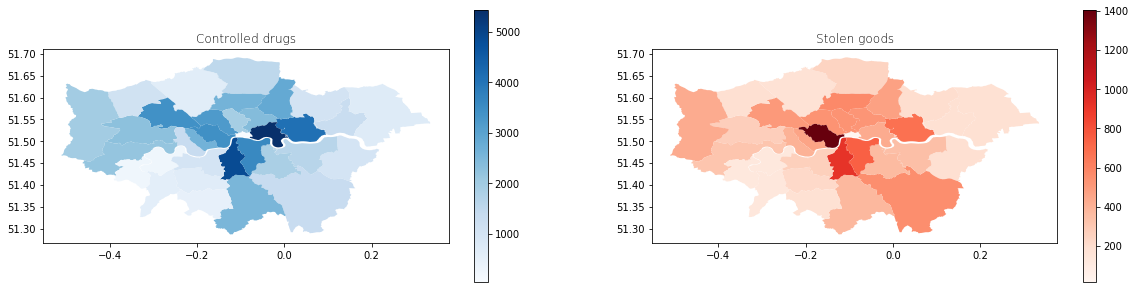

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

p1=boroughs3.plot(column='Controlled drugs',ax=axs[0],cmap='Blues',legend=True);
axs[0].set_title('Controlled drugs', fontdict={'fontsize': '12', 'fontweight' : '5'});

p2=boroughs3.plot(column='Stolen goods',ax=axs[1], cmap='Reds',legend=True);
axs[1].set_title('Stolen goods', fontdict={'fontsize': '12', 'fontweight' : '5'});


<div class="alert alert-success">
 <b>EXERCISE</b> <br/> 
 Explore the data with GeoPandas. Again there are no right or wrong answers, the questions below give you some suggestions at what to look at. <br/> 
   <ul>
  <li>Improve the above maps. How many arrests are there in each borough? Use the above method but first select only the arrests using the column 'Outcome'. Can you plot this? </li>
  <li>Are there changes over time? Is there a difference between months? Use `street` and look at Westminster or another borough where the crime rate seems higher. </li>    
  </ul> 
</div>  

In [51]:
# your data exploration (add as many cells as you need)


In [52]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer6.py

In [53]:
# %load https://raw.githubusercontent.com/IBMDeveloperUK/python-geopandas-workshop/master/answers/answer7.py

<a id="osm"></a>
## 5. OSM data

The Open Street Map data is also pre-processed in this [notebook]() so it is easier to read into this notebook. 

Data is downloaded from http://download.geofabrik.de/europe/great-britain.html and more details decription of the data is [here](http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf).

<a id="load3"></a>
### 5.1. Load data

In [54]:
download_file_to_local('london_inner_pois.zip', project=project)
pois = gpd.read_file("zip://./london_inner_pois.zip")
pois.head()

Attempting to get file london_inner_pois.zip
Downloading...
Completed writing to london_inner_pois.zip


,osm_id,code,fclass,name,geometry
0,108042,2304,pub,Simmons,POINT (-0.13553 51.52354)
1,108539,2566,bicycle_rental,Windsor Terrace,POINT (-0.09339 51.52913)
2,283885,2204,park,Ecology Park,POINT (0.01558 51.49497)
3,451152,2304,pub,The Dignity,POINT (-0.19461 51.60084)
4,451153,2301,restaurant,Central Restaurant,POINT (-0.19350 51.60203)


<a id="explore3"></a>
### 5.2. Explore data

In [55]:
pois.size

199495

In [56]:
pois['fclass'].unique()

array(['pub', 'bicycle_rental', 'park', 'restaurant', 'post_box',
       'library', 'post_office', 'public_building', 'bar', 'atm',
       'cinema', 'cafe', 'toilet', 'waste_basket', 'memorial', 'artwork',
       'monument', 'college', 'attraction', 'university', 'recycling',
       'supermarket', 'telephone', 'graveyard', 'laundry', 'courthouse',
       'pharmacy', 'convenience', 'bank', 'hotel', 'beverages',
       'fire_station', 'school', 'museum', 'playground', 'clothes',
       'recycling_paper', 'doctors', 'sports_centre', 'comms_tower',
       'hospital', 'car_sharing', 'bicycle_shop', 'camera_surveillance',
       'tower', 'recycling_clothes', 'ruins', 'police', 'chemist',
       'bakery', 'doityourself', 'embassy', 'tourist_info', 'fast_food',
       'theatre', 'viewpoint', 'water_works', 'arts_centre', 'fountain',
       'butcher', 'dentist', 'bookshop', 'community_centre',
       'kindergarten', 'newsagent', 'nightclub', 'car_rental', 'car_wash',
       'vending_any', 'vete

Count and plot the number of pubs by borough:

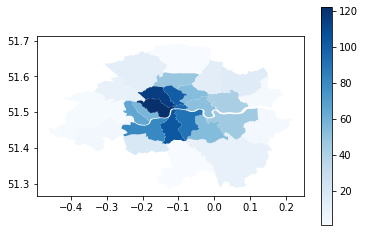

In [57]:
pubs = pois[pois['fclass']=='pub']

pubs2 = gpd.sjoin(boroughs,pubs) 
pubs3 = pd.pivot_table(pubs2,index='id',columns='fclass',aggfunc={'fclass':'count'})
pubs3.columns = pubs3.columns.droplevel()
pubs3 = pubs3.reset_index()
boroughs5 = boroughs.merge(pubs3, left_on='id',right_on='id')

boroughs5.plot(column='pub',cmap='Blues',legend=True);

<div class="alert alert-success">
 <b>EXERCISE</b> <br/> 
 Explore the data further. Again there are no right or wrong answers, the questions below give you some suggestions at what to look at. <br/> 
   <ul>
  <li> Is there a category of POIs that relates to the number of crimes? You might have to aggregate the data on a different more detailed level for this one. </li>
  <li> Can you find if there is a category of POIs that related to the number of crimes?  </li>
  <li> Count the number of crimes around a certain POI. Choose a point and use the buffer function from the top of the notebook. But note that the crimes are anonymised, so the exact location is not given, only an approximation.  </li>
       
  </ul> 
</div>  

In [58]:
# answers


Hopefully you got an idea of the possibilities with geospatial data now. There is a lot more to explore with this data. Let us know if you find anything interesting! We are on Twitter as @MargrietGr and @yaminigrao



### Author
Margriet Groenendijk is a Data & AI Developer Advocate for IBM. She develops and presents talks and workshops about data science and AI. She is active in the local developer communities through attending, presenting and organising meetups. She has a background in climate science where she explored large observational datasets of carbon uptake by forests during her PhD, and global scale weather and climate models as a postdoctoral fellow. 

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.